# How many stars will I give? Predicting ratings of Amazon reviews

----------------
## Purpose
Many product reviews (from other platforms than Amazon) are not accompanied by a scale rating system, consisting only of a textual evaluation. In this case, it becomes daunting and time-consuming to compare different products in order to eventually make a choice between them. Therefore, models able to predict the user rating from the text review are critically important. Getting an overall sense of a textual review could in turn improve consumer experience. Also, it can help business to increase sales, and improve the product by understanding customers' needs and pain-points.

The purpose of this project is to develop models that are able to predict the user rating from the text review. While our model is built to work with any kind of product, the review dataset provided by Amazon only includes Clothing and Shoes  reviews.
 
## Data-Source
Amazon product data:  http://jmcauley.ucsd.edu/data/amazon/

## Sample review:
    "reviewerID": "A2SUAM1J3GNN3B",  
    "asin": "0000013714",  
    "reviewerName": "J. McDonald",  
    "helpful": [2, 3],  
    "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  
    "overall": 5.0,  
    "summary": "Heavenly Highway Hymns",  
    "unixReviewTime": 1252800000,  
    "reviewTime": "09 13, 2009"  

----------------
## I. Preparing Amazon dataset

In [1]:
##########################################
## 1.1 IMPORT DATA IN PANDAS
##########################################
import pandas as pd
import numpy as np

review_df = pd.read_json('Amazon_reviews/Clothing_Shoes_and_Jewelry_5.json', orient='records', lines=True)

In [2]:
##########################################
## 1.2 CHECK DATA IN PANDAS
##########################################

# change column name 
review_df = review_df.rename(columns={'overall': 'Rating'})

print ("Total data:", str(review_df.shape))
review_df.head()

Total data: (278677, 9)


,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


## II. Preliminary Analysis

In [3]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(review_df)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(review_df.reviewerID.unique()))
reviewer_prop = float(len(review_df.reviewerID.unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(review_df.asin.unique()))
product_prop = float(len(review_df.asin.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(review_df.Rating.mean(),3))

print ("================================================")

Number of reviews:  278677

Number of unique reviewers:  39387
Prop of unique reviewers:  0.141

Number of unique products:  23033
Prop of unique products:  0.083

Average rating score:  4.245


In [4]:
##########################################
## 2.2 DISTRIBUTION OF RATING SCORE
########################################## 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = review_df.groupby('Rating').size()
class_counts

Rating
1     11192
2     15463
3     30425
4     58357
5    163240
dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

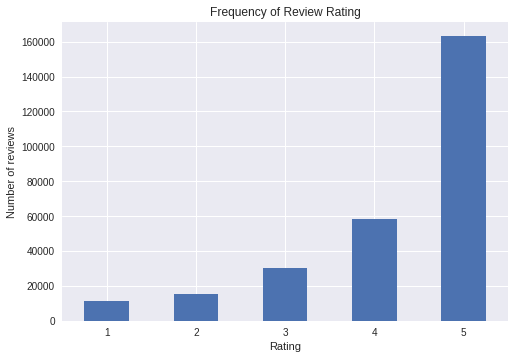

In [5]:
review_df.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

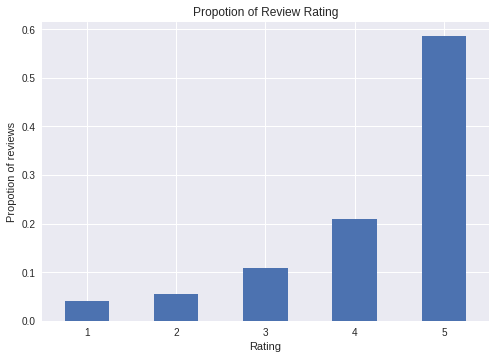

In [6]:
##########################################
## 2.3 DISTRIBUTION OF RATING PROPOTION
########################################## 

(review_df.groupby('Rating').size()/total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

In [8]:
######################
## 2.4 SUBSET DATA
######################

from datetime import datetime
def toDate(dt_str):
    return datetime.strptime(dt_str, '%m %d, %Y')

## select first 30,000 review
sub_df = review_df[0:30000]
sub_total = len(sub_df)
print (sub_total)

30000


In [9]:
class_counts = sub_df.groupby('Rating').size()
class_counts

Rating
1     1070
2     1541
3     2842
4     6042
5    18505
dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

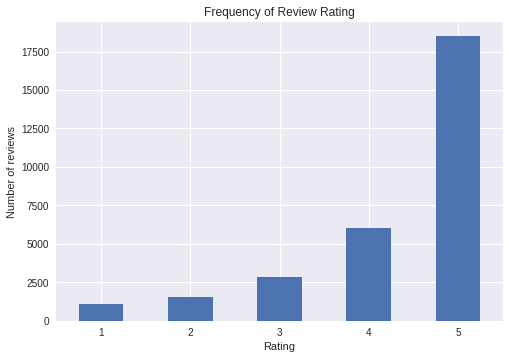

In [10]:
sub_df.groupby('Rating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

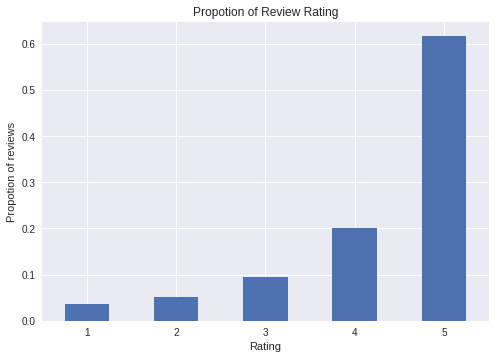

In [11]:
(sub_df.groupby('Rating').size()/sub_total).plot(kind='bar')
plt.title("Propotion of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Propotion of reviews")
plt.xticks(rotation=0)

## III. Pre-processing —— Text Normalization (Text Wrangling)
Text normalization is defined as a process that consists of a series of steps that should be followed to wrangle, clean, and standardize textual data into a form that
could be consumed by other NLP and analytics systems and applications as input. Besides tokenization, various other techniques include cleaning text, case conversion, correcting spellings,
removing stopwords and other unnecessary terms, stemming, and lemmatization. Text normalization is also often called text cleansing or wrangling.  

Below are various techniques used in the process of text normalization:
* __Cleaning Text__
* __Tokenizing Text__
* __Removing Special Characters__
* __Expanding Contractions__
* __Case Conversions__
* __Removing Stopwords__
* __Correcting Words__
* __Stemming__
* __Lemmatization__

In [12]:
import nltk
import re
import string

In [13]:
sdf = sub_df.copy()
sdf.index = range(sub_total)
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


### 1. Expanding Contractions
Contractions are shortened version of words or syllables. They exist in either written or spoken forms. Shortened versions of existing words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. 

By nature, contractions do pose a problem for NLP and text analytics because, to start with, we have a special apostrophe character in the word. Ideally, we can have a proper mapping for contractions and their corresponding expansions and then use it to expand all the contractions in our text. 

In [14]:
from contractions import CONTRACTION_MAP

# Define function to expand contractions
def expand_contractions(text):
    contractions_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match)\
                        if CONTRACTION_MAP.get(match)\
                        else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### 2. Removing Special Characters
One important task in text normalization involves removing unnecessary and *special characters*. These may be special symbols or even punctuation that occurs in sentences. This step is often performed before or after tokenization. The main reason for doing so is because often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML.

In [15]:
# Define the function to remove special characters
def remove_characters(text):
    text = text.strip()
    PATTERN = '[^a-zA-Z ]' # only extract alpha characters
    filtered_text = re.sub(PATTERN, '', text)
    return filtered_text

### 3. Tokenizing Text
Tokenization can be defined as the process of breaking down or splitting textual data into smaller meaningful components called tokens.  

**Sentence tokenization** is the process of splitting a text corpus into sentences that act as the first level of tokens which the corpus is comprised of. This is also known as sentence segmentation , because we try to segment the text into meaningful sentences.  

**Word tokenization** is the process of splitting or segmenting sentences into their constituent words. A sentence is a collection of words, and with tokenization we essentially split a sentence into a list of words that can be used to reconstruct the sentence.  

In [16]:
# Define the tokenization function
def tokenize_text(text):
    word_tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in word_tokens]
    return tokens

### 4. Removing Stopwords
*Stopwords* are words that have little or no significance. They are usually removed from text during processing so as to retain words having maximum significance and context. Stopwords are usually words that end up occurring the most if you aggregated any corpus of text based on singular tokens and checked their frequencies. Words like a, the , me , and so on are stopwords.

In [17]:
from nltk.corpus import stopwords
# In Python, searching a set is much faster than searching a list, 
# so convert the stop words to a set
stopword_list = set(stopwords.words("english"))

# Define function to remove stopwords
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

### 5. Correcting Words
One of the main challenges faced in text normalization is the presence of incorrect words in the text. The definition of incorrect here covers words that have spelling mistakes as well as words with several letters repeated that do not contribute much to its overall significance.

**5.1 Correcting Repeating Characters**

In [18]:
from nltk.corpus import wordnet

# Define function to remove repeated characters
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word

    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

**5.2 Correcting Spellings**

In [19]:
from collections import Counter

# Generate a map of frequently occurring words in English and their counts
"""
The input corpus we use is a file containing several books from the Gutenberg corpus and also 
a list of most frequent words from Wiktionary and the British National Corpus. You can find 
the file under the name big.txt or download it from http://norvig.com/big.txt and use it.
"""
def tokens(text):
    """
    Get all words from the corpus
    """
    return re.findall('[a-z]+', text.lower())

WORDS = tokens(open('big.txt').read())
WORD_COUNTS = Counter(WORDS)

In [20]:
# Define functions that compute sets of words that are one and two edits away from input word.
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [21]:
# Define function that returns a subset of words from our candidate set of words obtained from 
# the edit functions, based on whether they occur in our vocabulary dictionary WORD_COUNTS.
# This gives us a list of valid words from our set of candidate words.
def known(words): 
    "The subset of `words` that appear in the dictionary of WORD_COUNTS."
    return set(w for w in words if w in WORD_COUNTS)

In [22]:
# Define function to correct words
def correct(words):
    # Get the best correct spellings for the input words
    def candidates(word): 
        # Generate possible spelling corrections for word.
        # Priority is for edit distance 0, then 1, then 2, else defaults to the input word itself.
        candidates = known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
        return candidates
    
    corrected_words = [max(candidates(word), key=WORD_COUNTS.get) for word in words]
    return corrected_words

### 6. Lemmatization
The process of lemmatization is to remove word affixes to get to a base form of the word. The base form is also known as the root word, or the lemma, will always be present in the dictionary.

In [23]:
import spacy
nlp = spacy.load("en")

In [24]:
# Define function for Lemmatization
def Lemmatize_tokens(tokens):
    doc = ' '.join(tokens)
    Lemmatized_tokens = [token.lemma_ for token in nlp(doc)]
    return Lemmatized_tokens

### 7. Text Normalization

In [25]:
def normalize_corpus(corpus):
    normalized_corpus = []    
    for text in corpus:
        text = text.lower()
        text = expand_contractions(text)
        text = remove_characters(text)
        tokens = tokenize_text(text)
        tokens = remove_stopwords(tokens)
        tokens = remove_repeated_characters(tokens)
        tokens = correct(tokens)
        tokens = Lemmatize_tokens(tokens)
        text = ' '.join(tokens)
        normalized_corpus.append(text)
                    
    return normalized_corpus

In [26]:
# Normalize reviewText
sdf = sdf.assign(Norm_reviewText = normalize_corpus(sdf.reviewText))

In [27]:
sdf.head()

,asin,helpful,Rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Norm_reviewText
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800,great tut really great price look cheap glad l...
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600,buy or old daughter dance class wear today fir...
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600,say daughter orange black white pink thinking ...
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800,buy several titus get high review sturdy seemi...
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600,thank halo heaven great product little girl gr...


In [28]:
# Save data sets to files
sdf.to_csv('normalized_sub-corpus-30k.csv', index=False)

## IV. Feature Engineering

### 1. Bag of Words Model

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range, max_features = 5000)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

### 2. TF-IDF Model 
TF-IDF stands for Term Frequency-Inverse Document Frequency, a combination of two metrics: term frequency and inverse document frequency.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define function to directly compute the tfidf-based feature vectors for documents from the raw documents.
def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range,
                                 max_features = 5000)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

### 3. Averaged Word Vectors

In [31]:
import numpy as np    

# Define function to average word vectors for a text document
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [32]:
# Generalize above function for a corpus of documents  
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(sentence, model, vocabulary, num_features) for sentence in corpus]
    return np.array(features)

### 4. TF-IDF Weighted Averaged Word Vectors

In [33]:
# Define function to compute tfidf weighted averaged word vector for a document
def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]    
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index2word)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector

In [34]:
# Generalize above function for a corpus of documents
def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features) 

## V. Machine Learning

### 1. Split data into train and test sets

In [35]:
from sklearn.model_selection import train_test_split

X = sdf.Norm_reviewText
Y = sdf.Rating
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(24000,)
(6000,)
(24000,)
(6000,)


In [36]:
train_corpus, test_corpus = train_X.values.astype('U'), test_X.values.astype('U')
train_labels, test_labels = train_Y, test_Y

### 2. Feature Extraction for train and test sets

In [37]:
# Define function to display feature names
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print (df)

In [38]:
feature_set = []

* __Bag of Words Features__

In [39]:
# bag of words features
bow_vectorizer, bow_train_features = bow_extractor(train_corpus)  
bow_test_features = bow_vectorizer.transform(test_corpus) 
feature_set.append(('Bag of words features', bow_train_features, bow_test_features))

In [40]:
# Print feature names
feature_names = bow_vectorizer.get_feature_names()
print (feature_names)

['ab', 'abdominal', 'ability', 'able', 'abolish', 'about', 'abrasion', 'abroad', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbent', 'absurd', 'abuse', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessible', 'accessory', 'accident', 'accidentally', 'accidently', 'accommodate', 'accompany', 'accomplish', 'accord', 'accordingly', 'account', 'accuracy', 'accurate', 'accurately', 'accustomed', 'ache', 'achieve', 'achille', 'acorn', 'acquire', 'across', 'acrylic', 'act', 'action', 'activate', 'active', 'activity', 'actual', 'actually', 'acutely', 'ad', 'adam', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'adequate', 'adequately', 'adhere', 'adhesive', 'adjust', 'adjustable', 'adjusted', 'adjustment', 'admire', 'admit', 'admittedly', 'adorable', 'adore', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advertise', 'advertised', 'advertisement', 'advertising', 'advice', 'advise', 'advocate', 'aerobic', 'aesthetic', 'aesthetically', '

In [41]:
features_bow = bow_train_features.todense()
display_features(features_bow[0:5], feature_names)

   ab  abdominal  ability  able  abolish  about  abrasion  abroad  absent  \
0   0          0        0     0        0      0         0       0       0   
1   0          0        0     0        0      0         0       0       0   
2   0          0        0     0        0      0         0       0       0   
3   0          0        0     0        0      0         0       0       0   
4   0          0        0     0        0      0         0       0       0   

   absolute  ...   yet  yoke  york  young  youth  zealand  zenger  zero  zip  \
0         0  ...     0     0     0      0      0        0       0     0    0   
1         0  ...     0     0     0      0      0        0       0     0    0   
2         0  ...     0     0     0      0      0        0       0     0    0   
3         0  ...     0     0     0      0      0        0       0     0    0   
4         0  ...     0     0     0      0      0        0       0     0    0   

   zone  
0     0  
1     0  
2     0  
3     0  
4     

* __TF-IDF Features__

In [42]:
# tfidf features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)
feature_set.append(('Tfidf features', tfidf_train_features, tfidf_test_features))

In [43]:
# Print feature names
feature_names = tfidf_vectorizer.get_feature_names()
print (feature_names)

['ab', 'abdominal', 'ability', 'able', 'abolish', 'about', 'abrasion', 'abroad', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbent', 'absurd', 'abuse', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessible', 'accessory', 'accident', 'accidentally', 'accidently', 'accommodate', 'accompany', 'accomplish', 'accord', 'accordingly', 'account', 'accuracy', 'accurate', 'accurately', 'accustomed', 'ache', 'achieve', 'achille', 'acorn', 'acquire', 'across', 'acrylic', 'act', 'action', 'activate', 'active', 'activity', 'actual', 'actually', 'acutely', 'ad', 'adam', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'adequate', 'adequately', 'adhere', 'adhesive', 'adjust', 'adjustable', 'adjusted', 'adjustment', 'admire', 'admit', 'admittedly', 'adorable', 'adore', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advertise', 'advertised', 'advertisement', 'advertising', 'advice', 'advise', 'advocate', 'aerobic', 'aesthetic', 'aesthetically', '

In [44]:
features = tfidf_train_features.todense()
features_tfidf = np.round(features, 2)
display_features(features_tfidf[0:5], feature_names)

    ab  abdominal  ability  able  abolish  about  abrasion  abroad  absent  \
0  0.0        0.0      0.0   0.0      0.0    0.0       0.0     0.0     0.0   
1  0.0        0.0      0.0   0.0      0.0    0.0       0.0     0.0     0.0   
2  0.0        0.0      0.0   0.0      0.0    0.0       0.0     0.0     0.0   
3  0.0        0.0      0.0   0.0      0.0    0.0       0.0     0.0     0.0   
4  0.0        0.0      0.0   0.0      0.0    0.0       0.0     0.0     0.0   

   absolute  ...   yet  yoke  york  young  youth  zealand  zenger  zero  zip  \
0       0.0  ...   0.0   0.0   0.0    0.0    0.0      0.0     0.0   0.0  0.0   
1       0.0  ...   0.0   0.0   0.0    0.0    0.0      0.0     0.0   0.0  0.0   
2       0.0  ...   0.0   0.0   0.0    0.0    0.0      0.0     0.0   0.0  0.0   
3       0.0  ...   0.0   0.0   0.0    0.0    0.0      0.0     0.0   0.0  0.0   
4       0.0  ...   0.0   0.0   0.0    0.0    0.0      0.0     0.0   0.0  0.0   

   zone  
0   0.0  
1   0.0  
2   0.0  
3   0.0  


* __Averaged Word Vector Features__

In [45]:
# tokenize documents
tokenized_train = [nltk.word_tokenize(text) for text in train_corpus]
tokenized_test = [nltk.word_tokenize(text) for text in test_corpus]

In [46]:
import gensim

# build word2vec model                   
model = gensim.models.Word2Vec(tokenized_train,
                               size=5000,
                               window=100,
                               min_count=2,
                               sample=1e-3) 

In [47]:
# averaged word vector features
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                 model=model,
                                                 num_features=5000)                   
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                model=model,
                                                num_features=5000) 
feature_set.append(('Averaged word vector features', avg_wv_train_features, avg_wv_test_features))

In [48]:
# Print test features
print (np.round(avg_wv_test_features, 3))

[[-0.009  0.065 -0.076 ..., -0.026 -0.001  0.076]
 [ 0.033  0.539 -0.5   ...,  0.073  0.087 -0.023]
 [ 0.063  0.545 -0.355 ..., -0.121 -0.078 -0.048]
 ..., 
 [ 0.129  0.565 -0.377 ..., -0.049  0.046  0.053]
 [ 0.054  0.172 -0.232 ..., -0.171 -0.111  0.248]
 [ 0.057  0.241 -0.168 ..., -0.064  0.015  0.026]]


* __TF-IDF Weighted Averaged Word Vector features__

In [49]:
# tfidf weighted averaged word vector features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train, 
                                                                  tfidf_vectors=tfidf_train_features, 
                                                                  tfidf_vocabulary=vocab, 
                                                                  model=model, 
                                                                  num_features=5000)
tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test, 
                                                                 tfidf_vectors=tfidf_test_features, 
                                                                 tfidf_vocabulary=vocab, 
                                                                 model=model, 
                                                                 num_features=5000)
feature_set.append(('Tfidf weighted averaged word vector features', 
                    tfidf_wv_train_features, tfidf_wv_test_features))

In [50]:
# Print test features
print (np.round(tfidf_wv_test_features, 3))

[[  4.00000000e-03   1.03000000e-01  -9.20000000e-02 ...,  -3.00000000e-02
    1.00000000e-03   5.00000000e-02]
 [  1.75000000e-01   1.48900000e+00  -1.30300000e+00 ...,   2.56000000e-01
    2.75000000e-01  -2.06000000e-01]
 [  4.30000000e-02   5.59000000e-01  -3.66000000e-01 ...,  -1.02000000e-01
   -8.10000000e-02  -5.80000000e-02]
 ..., 
 [  1.02000000e-01   4.81000000e-01  -3.28000000e-01 ...,  -3.50000000e-02
    3.70000000e-02   6.30000000e-02]
 [  5.40000000e-02   1.00000000e-01  -2.01000000e-01 ...,  -1.82000000e-01
   -1.32000000e-01   3.32000000e-01]
 [  4.50000000e-02   2.02000000e-01  -1.41000000e-01 ...,  -5.50000000e-02
    1.80000000e-02   1.80000000e-02]]


### 3. Function for Evaluating Classification Models

In [51]:
from sklearn.metrics import accuracy_score, classification_report

def get_metrics(true_labels, predicted_labels):
    print ('Accuracy: ', accuracy_score(true_labels,predicted_labels))
    print (classification_report(true_labels, predicted_labels))

In [52]:
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    train_predictions = classifier.predict(train_features)
    test_predictions = classifier.predict(test_features) 
    # evaluate model prediction performance 
    print ('Training set performance:')
    get_metrics(true_labels=train_labels, predicted_labels=train_predictions)
    print ('Test set performance:')
    get_metrics(true_labels=test_labels, predicted_labels=test_predictions)
    return test_predictions    

### 4. Develop and Evaluate Models

In [53]:
# Build ML methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Put all models in a main model
models = []
models.append(('LR', LogisticRegression()))
models.append(('MNB', MultinomialNB()))
models.append(('LSVC', LinearSVC()))
models.append(('SGD', SGDClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [54]:
# Train, predict and evaluate models
predict_result = []
for m_name, model in models:
    print('==================================================')
    print('Model:', m_name)
    for f_name, train_features, test_features in feature_set:
        if m_name=='MNB':
            if (f_name=='Averaged word vector features' or f_name=='Tfidf weighted averaged word vector features'):
                break
        print(f_name)
        predictions = train_predict_evaluate_model(model, train_features, train_labels, test_features, test_labels)
        print('--------------------------------------------------')
        predict_result.append((m_name, f_name, predictions))

Model: LR
Bag of words features
Training set performance:
Accuracy:  0.790166666667
             precision    recall  f1-score   support

          1       0.90      0.67      0.77       856
          2       0.86      0.55      0.67      1233
          3       0.77      0.52      0.62      2273
          4       0.71      0.47      0.57      4834
          5       0.80      0.96      0.87     14804

avg / total       0.78      0.79      0.77     24000

Test set performance:
Accuracy:  0.653666666667
             precision    recall  f1-score   support

          1       0.48      0.25      0.33       214
          2       0.35      0.20      0.26       308
          3       0.34      0.23      0.27       569
          4       0.41      0.26      0.32      1208
          5       0.74      0.91      0.81      3701

avg / total       0.60      0.65      0.62      6000

--------------------------------------------------
Tfidf features
Training set performance:
Accuracy:  0.703458333333
  

/home/toniachu/ProgramFiles/Anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training set performance:
Accuracy:  0.835583333333
             precision    recall  f1-score   support

          1       0.95      0.87      0.91       856
          2       0.91      0.77      0.83      1233
          3       0.84      0.67      0.74      2273
          4       0.77      0.54      0.64      4834
          5       0.84      0.96      0.89     14804

avg / total       0.83      0.84      0.83     24000

Test set performance:
Accuracy:  0.629833333333
             precision    recall  f1-score   support

          1       0.37      0.31      0.34       214
          2       0.28      0.24      0.26       308
          3       0.29      0.23      0.26       569
          4       0.36      0.25      0.30      1208
          5       0.75      0.87      0.80      3701

avg / total       0.59      0.63      0.61      6000

--------------------------------------------------
Tfidf features
Training set performance:
Accuracy:  0.78325
             precision    recall  f1-scor

### 5. Confusion Matrix of Models

In [55]:
from sklearn.metrics import confusion_matrix

for m_name, f_name, predictions in predict_result:
    print("Model {} with {}:".format(m_name, f_name))
    cm = confusion_matrix(test_labels, predictions)
    print(pd.DataFrame(cm, index=range(1,6), columns=range(1,6)))
    print()

Model LR with Bag of words features:
    1   2    3    4     5
1  54  42   19   20    79
2  20  62   60   47   119
3  21  45  129  155   219
4   8  16   93  318   773
5   9  11   77  245  3359

Model LR with Tfidf features:
    1   2   3    4     5
1  32  28  27   21   106
2  12  26  59   47   164
3   3  19  99  161   287
4   2   6  55  272   873
5   0   4  21  157  3519

Model LR with Averaged word vector features:
    1  2   3    4     5
1  14  4  26   23   147
2   7  7  37   55   202
3   0  4  42  136   387
4   2  0  28  214   964
5   6  4  12  112  3567

Model LR with Tfidf weighted averaged word vector features:
   1  2   3    4     5
1  7  2  25   23   157
2  5  7  32   47   217
3  1  2  29  124   413
4  1  1  25  197   984
5  4  2  17  102  3576

Model MNB with Bag of words features:
    1   2    3    4     5
1  65  48   32   23    46
2  30  55   83   55    85
3  14  53  151  172   179
4   9  30  128  383   658
5  23  32   89  389  3168

Model MNB with Tfidf features:
   1  2  3

### 6. Hyperparameter Tuning

In [56]:
from sklearn.model_selection import GridSearchCV

def get_optimal_parameters(classifier, param_grid, 
                    train_features, train_labels, 
                    test_features, test_labels):
    # Instantiate the GridSearchCV object
    classifier_cv = GridSearchCV(classifier, param_grid, cv=5)
    # build model    
    classifier_cv.fit(train_features, train_labels)
    # predict using model
    test_predictions = classifier_cv.predict(test_features) 
    print("Tuned Parameter: {}".format(classifier_cv.best_params_))
    print("Tuned Score: {}".format(classifier_cv.best_score_))
    print()
    # evaluate model prediction performance 
    print ('Test set performance:')
    get_metrics(true_labels=test_labels, predicted_labels=test_predictions)
    # Print the optimal parameters and best score
    return classifier_cv

* __Logistic Regression__

In [57]:
# Create the hyperparameter grid
c_space = np.logspace(-3, 2, 9)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

In [59]:
# Logistic Regression with bag of words features
LR_bow_model = get_optimal_parameters(classifier=LogisticRegression(), 
                                    param_grid=param_grid, 
                                    train_features=bow_train_features,
                                    train_labels=train_labels,
                                    test_features=bow_test_features,
                                    test_labels=test_labels)

Tuned Parameter: {'C': 0.31622776601683794, 'penalty': 'l1'}
Tuned Score: 0.65825

Test set performance:
Accuracy:  0.6605
             precision    recall  f1-score   support

          1       0.49      0.22      0.31       214
          2       0.32      0.10      0.15       308
          3       0.38      0.18      0.25       569
          4       0.43      0.24      0.31      1208
          5       0.72      0.94      0.82      3701

avg / total       0.60      0.66      0.61      6000



In [60]:
# Create the hyperparameter grid
c_space = np.logspace(-3, 2, 9)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

In [61]:
# Logistic Regression with tfidf features
LR_tfidf_model = get_optimal_parameters(classifier=LogisticRegression(), 
                                        param_grid=param_grid, 
                                        train_features=tfidf_train_features,
                                        train_labels=train_labels,
                                        test_features=tfidf_test_features,
                                        test_labels=test_labels)

Tuned Parameter: {'C': 1.333521432163324, 'penalty': 'l1'}
Tuned Score: 0.661375

Test set performance:
Accuracy:  0.662
             precision    recall  f1-score   support

          1       0.58      0.24      0.34       214
          2       0.33      0.11      0.17       308
          3       0.39      0.19      0.26       569
          4       0.42      0.24      0.31      1208
          5       0.72      0.94      0.82      3701

avg / total       0.60      0.66      0.61      6000



* __Multinomial Naive Bayes__

In [62]:
# Create the hyperparameter grid
alpha_space = np.logspace(-3, 3, 10)
param_grid = {'alpha': alpha_space}

In [63]:
# Multinomial Naive Bayes with bag of words features
MNB_bow_model = get_optimal_parameters(classifier=MultinomialNB(), 
                                    param_grid=param_grid, 
                                    train_features=bow_train_features,
                                    train_labels=train_labels,
                                    test_features=bow_test_features,
                                    test_labels=test_labels)

Tuned Parameter: {'alpha': 2.154434690031882}
Tuned Score: 0.6335833333333334

Test set performance:
Accuracy:  0.636166666667
             precision    recall  f1-score   support

          1       0.50      0.22      0.31       214
          2       0.28      0.13      0.17       308
          3       0.29      0.21      0.25       569
          4       0.36      0.32      0.34      1208
          5       0.75      0.87      0.81      3701

avg / total       0.60      0.64      0.61      6000



* __Linear Support Vector Classification__

In [64]:
# Create the hyperparameter grid
c_space = np.logspace(-3, 2, 10)
param_grid = {'C': c_space}

In [65]:
# Linear Support Vector Classification with tfidf features                                           
LSVC_tfidf_model = get_optimal_parameters(classifier=LinearSVC(), param_grid=param_grid, 
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

Tuned Parameter: {'C': 0.1668100537200059}
Tuned Score: 0.6562083333333333

Test set performance:
Accuracy:  0.662166666667
             precision    recall  f1-score   support

          1       0.62      0.21      0.32       214
          2       0.36      0.12      0.18       308
          3       0.37      0.17      0.23       569
          4       0.41      0.23      0.30      1208
          5       0.72      0.95      0.82      3701

avg / total       0.60      0.66      0.61      6000



* __SGD Classifier__

In [66]:
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 20)
param_grid = {'l1_ratio': l1_space}

In [67]:
# SGD Classifier with tfidf features 
SGD_tfidf_model = get_optimal_parameters(classifier=SGDClassifier(), 
                                         param_grid=param_grid,
                                         train_features=tfidf_train_features,
                                         train_labels=train_labels,
                                         test_features=tfidf_test_features,
                                         test_labels=test_labels)

Tuned Parameter: {'l1_ratio': 0.84210526315789469}
Tuned Score: 0.653625

Test set performance:
Accuracy:  0.657833333333
             precision    recall  f1-score   support

          1       0.54      0.26      0.35       214
          2       0.40      0.13      0.20       308
          3       0.41      0.19      0.26       569
          4       0.42      0.13      0.19      1208
          5       0.70      0.97      0.81      3701

avg / total       0.59      0.66      0.59      6000



* __Random Forest Classifier__

In [68]:
# Create the hyperparameter grid
n_options = [10,20,50,100,200]
sample_leaf_options = [1,5,10,50,100,200,500]
param_grid = {'n_estimators': n_options, 'min_samples_leaf': sample_leaf_options}

In [69]:
# Random Forest Classifier with averaged word vector features
RFC_avgwv_model = get_optimal_parameters(classifier=RandomForestClassifier(), 
                                         param_grid=param_grid,
                                         train_features=avg_wv_train_features,
                                         train_labels=train_labels,
                                         test_features=avg_wv_test_features,
                                         test_labels=test_labels)

Tuned Parameter: {'min_samples_leaf': 10, 'n_estimators': 200}
Tuned Score: 0.635625

Test set performance:
Accuracy:  0.636666666667
             precision    recall  f1-score   support

          1       0.57      0.06      0.11       214
          2       0.24      0.04      0.06       308
          3       0.27      0.07      0.11       569
          4       0.35      0.17      0.23      1208
          5       0.68      0.96      0.80      3701

avg / total       0.55      0.64      0.56      6000

